In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

def getAudioSize():
    AUDIO_SIZE = 30500
    return AUDIO_SIZE

In [4]:
train_data = pd.read_csv('../inputFile/modelInput/allFileCombineP.csv')
# train_data.drop(['url_legal', 'license', 'standard_error'], axis=1, inplace=True)
train_data.head(3)

(3934500, 10)


In [28]:
# define X, y and test
X_train_RMS = train_data.RMS
X_train_F0 = train_data.F0Log10
X_train_MfCC1 = train_data.MFCC1

X_train =  train_data[['RMS', 'F0Log10', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5']]

Y_train = train_data[['Arousal']]

print(X_train.shape)
print(X_train.head(5))
print(Y_train.head(5))

(3934500, 7)
        RMS   F0Log10      MFCC1      MFCC2      MFCC3      MFCC4      MFCC5
0  0.000996  1.812569 -511.43164  34.346817  20.143454  15.775600  15.375603
1  0.001178  3.498311 -505.33768  42.232910  25.820728  19.119133  17.744923
2  0.001057  2.411956 -512.99567  34.188824  23.477936  21.108840  19.648773
3  0.000986  1.818614 -510.94208  36.092613  22.873180  17.580963  14.751257
4  0.000969  1.865542 -510.60342  35.844406  24.288557  22.082817  19.130995
   Arousal
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0


In [29]:
def create_model():
    model = keras.Sequential([
        layers.Dense(units=512, kernel_initializer='normal', activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.25),
        layers.Dense(units=256, kernel_initializer='normal', activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(units=128, kernel_initializer='normal', activation='relu'),
        layers.Dropout(0.25),
        # the linear output layer 
        layers.Dense(units=1, kernel_initializer='normal', activation='linear'),
    ])
    
    model.compile(optimizer = 'adam', loss='mean_squared_error')
    
    return model

In [34]:
# Hyper-parameters
validation_split=(26/129)
epochs=50

# Create a KerasClassifier with best parameters
model_KR = KerasRegressor(build_fn = create_model, batch_size = getAudioSize(), epochs = epochs)

# Calculate the accuracy score for each fold
kfolds = cross_val_score(model_KR, X_train, Y_train, cv = 10)

#get the accuracy
print(kfolds.mean())
print('The mean accuracy:', kfolds.mean())

Epoch 1/50
117/117 [==============================] - 2s 13ms/step - loss: 0.8100
Epoch 2/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0204
Epoch 3/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0198
Epoch 4/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0196
Epoch 5/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0193
Epoch 6/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0188
Epoch 7/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0185
Epoch 8/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0182
Epoch 9/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0181
Epoch 10/50
117/117 [==============================] - 1s 11ms/step - loss: 0.0181
Epoch 11/50
117/117 [==============================] - 1s 11ms/step - loss: 0.0180
Epoch 12/50
117/117 [==============================] - 1s 12ms/step - loss: 0.0179
Epoch 13/50
1

In [35]:
#use callbacks
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("", monitor="val_loss", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto', restore_best_weights=True)

In [38]:
history = model_KR.fit(
    X_train, Y_train,
    validation_split=validation_split,
    batch_size=getAudioSize(),
    epochs=epochs,
    callbacks = [early_stop, checkpoint, reduce_lr]
)

Epoch 1/50
103/103 [==============================] - 2s 18ms/step - loss: 0.5870 - val_loss: 0.0193

Epoch 00001: val_loss did not improve from 0.01920
Epoch 2/50
103/103 [==============================] - 2s 16ms/step - loss: 0.0195 - val_loss: 0.0192

Epoch 00002: val_loss improved from 0.01920 to 0.01917, saving model to 
INFO:tensorflow:Assets written to: assets
Epoch 3/50
103/103 [==============================] - 2s 17ms/step - loss: 0.0188 - val_loss: 0.0192

Epoch 00003: val_loss did not improve from 0.01917
Epoch 4/50
103/103 [==============================] - 2s 17ms/step - loss: 0.0184 - val_loss: 0.0194

Epoch 00004: val_loss did not improve from 0.01917
Epoch 5/50
103/103 [==============================] - 2s 16ms/step - loss: 0.0179 - val_loss: 0.0193

Epoch 00005: val_loss did not improve from 0.01917
Epoch 6/50
103/103 [==============================] - 2s 15ms/step - loss: 0.0172 - val_loss: 0.0193

Epoch 00006: val_loss did not improve from 0.01917
Epoch 7/50
103/103

<AxesSubplot:>

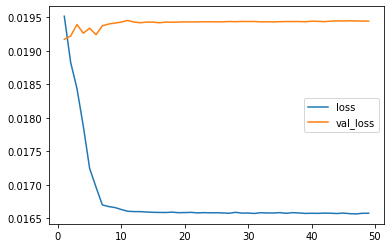

In [40]:
import matplotlib as plt
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()